In [64]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [65]:
env = BlackjackEnv()

In [66]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [89]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        values = Q[observation]
        max_value = np.max(values)
        indices = [i for i,x in enumerate(values) if x == max_value]
        new_policy = np.zeros(values.shape)
        new_policy[indices] = 1/len(indices)
        return new_policy
    
    return policy_fn

In [90]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    overall_weight = defaultdict(float)
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        ##Generate an episode using behavior_policy
        episode = []
        observation = env.reset()
        while (True):
            previous_observation = observation
            action_probs = behavior_policy(observation)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            observation, reward, done, _ = env.step(action)
            episode.append((previous_observation, action, reward))
            if done:
                break
            #action = np.random.choice(np.arange(len(probs)), p=probs)
    
        ##For each segment of the episode where we follow the target policy
        ##use the observed values to update the target policy's Q matrix
        ##To do this we should loop backwards because we need the episode to terminate
        ##to get an estimate of the value
        ##This means we can only use the tail-ends of episodes generated this way
        ##We can only use segments that follow the target policy because
        ##otherwise they do not give an accurate estimate of the value of the
        ##policy
        #if (len(episode) > 5):
        #    print("Generated an episode of length %d", len(episode))
        returns = 0
        weight = 1
        for j in range(len(episode))[::-1]:            
            returns = discount_factor*returns+episode[j][2]
            observation, action, reward = episode[j]
            overall_weight[(observation, action)] += weight
            Q[observation][action] += (weight/overall_weight[(observation, action)])*(returns - Q[observation][action])
            weight = weight*target_policy(observation)[action]/behavior_policy(observation)[action]
            if weight == 0:
                break
        target_policy = create_greedy_policy(Q)
        
    return Q, target_policy

In [91]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

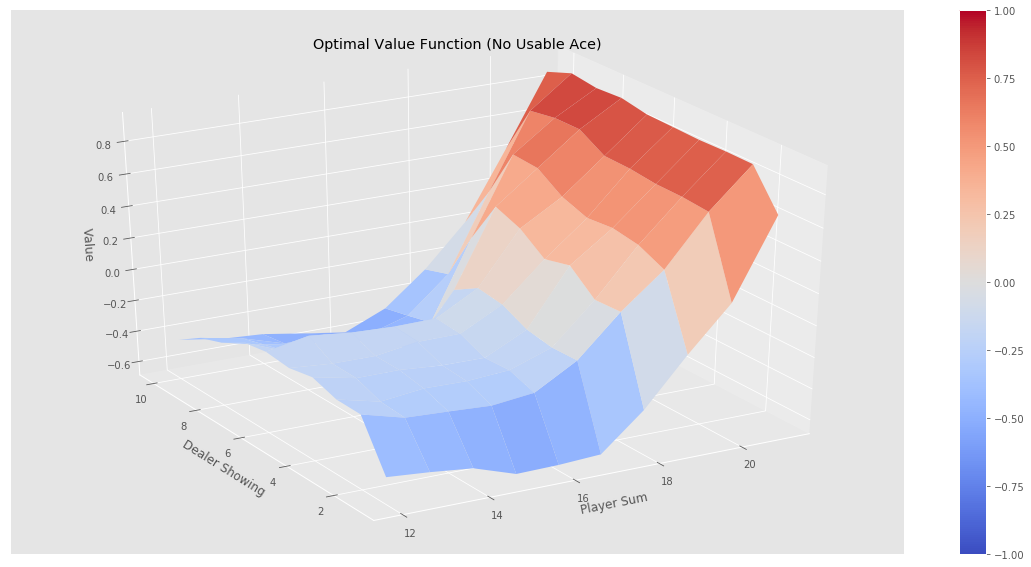

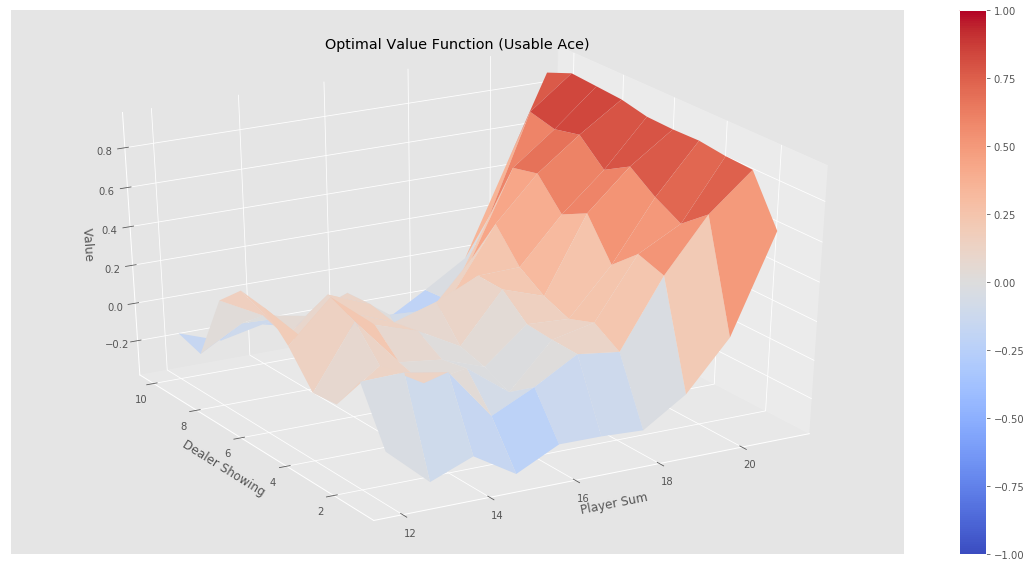

In [92]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")